## Assignment 3 Google Stock Price Prediction using RNN , LSTM, GRU (5 years)
This notebook focuses on experimenting recent 10 years of Google stock price    
Period: Nov 18, 2017 - Nov 19, 2022    
model: RNN , LSTM, GRU    
sequence length: 10, 50, 100    
learning rate: 0.1, 0.001    

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import seaborn as sns
import matplotlib.dates as mdates 
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from keras.callbacks import EarlyStopping

# Data preprocessing
- split into training, validation and testing

In [3]:
# read all the google data
data = pd.read_csv('GOOG_5_years.csv', date_parser = True)
# overwriting data after changing format
data["Date"]= pd.to_datetime(data["Date"])
data = data.set_index('Date')
data = data.sort_values(by = ['Date'])
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-14,95.500000,97.180000,95.112999,96.029999,96.029999,24170100
2022-11-15,98.669998,100.419998,97.019997,98.720001,98.720001,31831000
2022-11-16,98.019997,99.849998,97.902000,98.989998,98.989998,24660200
2022-11-17,97.180000,99.480003,97.099998,98.500000,98.500000,21818700
2022-11-18,99.010002,99.160004,96.739998,97.800003,97.800003,24959300


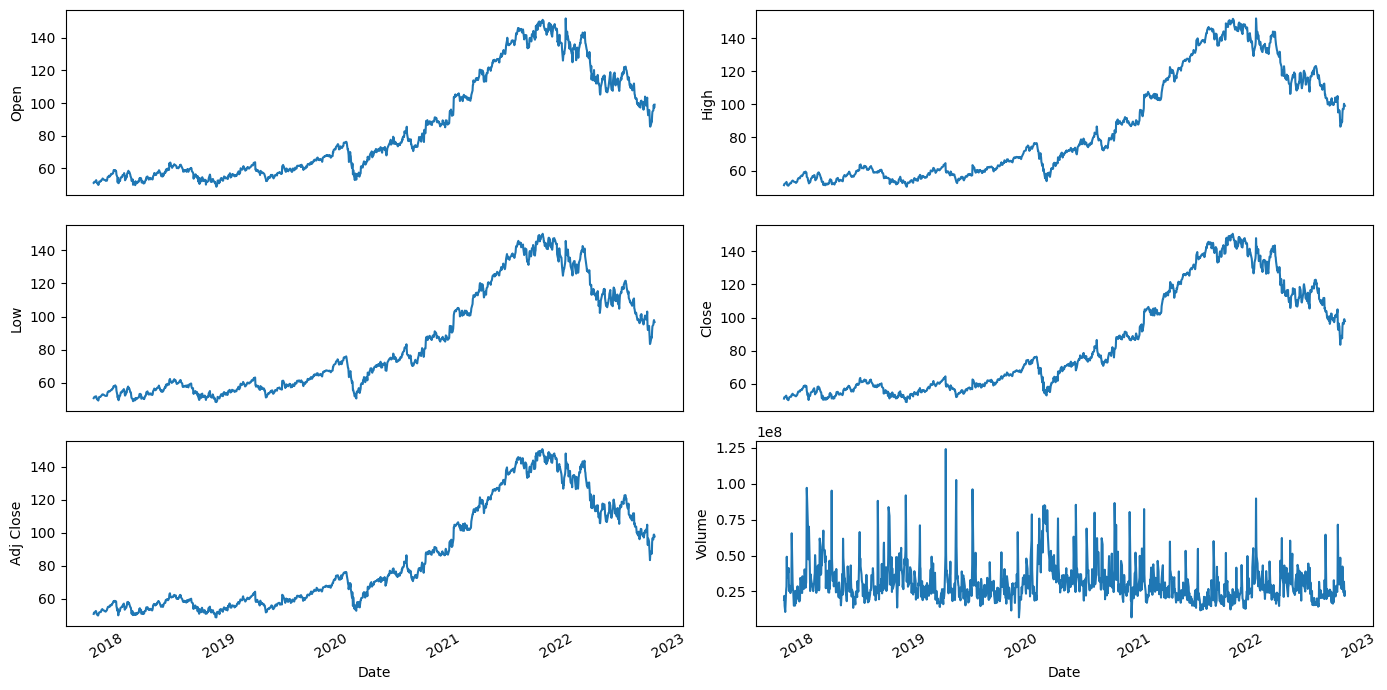

In [4]:
# Plot line charts
df_plot = data.copy()
#df_plot =df_plot.set_index('Date')
# df_plot.drop(['Date'], axis = 1 , inplace=True)

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [5]:
#drop the useless column
data = data.drop([ 'Adj Close'], axis = 1)

In [6]:
# split the data into training validation and testing 80/10/10
training_size = round((data.shape[0]*0.1)*8)
validation_size = round((data.shape[0]*0.1)*9)
test_size = round((data.shape[0]))
print(training_size,validation_size,test_size)

1007 1133 1259


In [7]:
# split the data into training validation and testing 80/10/10
# this is still dataframe
data_training = data.copy().iloc[:training_size, :]
data_validation = data.copy().iloc[training_size:validation_size, :]
data_test =data.copy().iloc[validation_size:test_size, :].copy()
data_training

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-20,51.013000,51.130501,50.875000,50.918999,19070000
2017-11-21,51.165501,51.755501,51.132751,51.724499,21940000
2017-11-22,51.750000,51.985298,51.571499,51.798000,14926000
2017-11-24,51.793499,52.158901,51.750000,52.030499,10740000
2017-11-27,52.000000,52.772999,51.922001,52.710499,26158000
...,...,...,...,...,...
2021-11-12,147.831497,149.859497,146.453995,149.645493,17048000
2021-11-15,150.000000,150.477005,148.652496,149.388000,16248000
2021-11-16,149.170502,149.832504,148.350006,149.076004,17254000


In [8]:
# # split the data into training validation and testing 80/10/10
# data_training = data[data['Date']<'2021-01-01'].copy()
# data_validation = data[data['Date']<'2021-01-01'].copy()
# data_test = data[data['Date']>='2021-01-01'].copy()

In [9]:
# print the size of the data
print(data_training.shape[0], data_validation.shape[0], data_test.shape[0])

1007 126 126


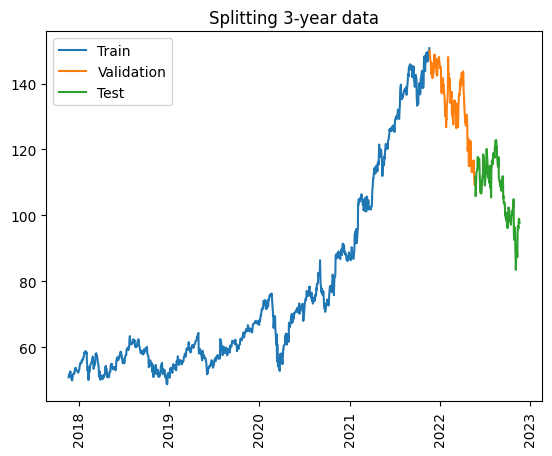

In [10]:
#plot the actual closing price for train, validation and test in 5 years
plt.plot(data_training.index, data_training.Close)
plt.plot(data_validation.index, data_validation.Close)
plt.plot(data_test.index, data_test.Close)
plt.title("Splitting 5-year data")
plt.xticks(rotation=90)
plt.legend(['Train', 'Validation', 'Test'])

In [11]:
# use min max scale
scaler_RNN = MinMaxScaler()

# scaled the training data in numpy array
scaled_data_training = scaler_RNN.fit_transform(data_training) # scaled the training data

# scaled the validation data in numpy array
scaled_data_validation = scaler_RNN.fit_transform(data_validation)

# scaled the testing data in numpy array
scaled_data_test = scaler_RNN.fit_transform(data_test)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
# df_training_Close = pd.DataFrame(data_training['Close'])
df_training_Close = pd.DataFrame(data['Close'])
scaled_training_Close = scaler_pred.fit_transform(df_training_Close)

In [12]:
df_training_Close

,Close
Date,
2017-11-20,50.918999
2017-11-21,51.724499
2017-11-22,51.798000
2017-11-24,52.030499
2017-11-27,52.710499
...,...
2022-11-14,96.029999
2022-11-15,98.720001
2022-11-16,98.989998


In [13]:
def partition_dataset(window_size, data):
    #using for loop to create the slide window
    X = []
    y = []

    for i in range(window_size, data.shape[0]):
        X.append(data[i-window_size:i])
        y.append(data[i, 3])

    X, y = np.array(X), np.array(y)
    
    return X, y 

In [14]:
# create differernt sequence length 10, 50 ,100
# sequence length of 10
def window_mod(ipt):
    if ipt == 10:
        window_size_10 = 10

        X_train_ten, y_train_ten = partition_dataset(window_size_10, scaled_data_training)
        X_val_ten, y_val_ten = partition_dataset(window_size_10, scaled_data_validation)
        X_test_ten, y_test_ten = partition_dataset(window_size_10, scaled_data_test)
        return X_train_ten, y_train_ten,X_val_ten, y_val_ten,X_test_ten, y_test_ten 

    # sequence length of 50
    elif ipt == 50:
        window_size_50 = 50

        X_train_fifty, y_train_fifty = partition_dataset(window_size_50, scaled_data_training)
        X_val_fifty, y_val_fifty = partition_dataset(window_size_50, scaled_data_validation)
        X_test_fifty, y_test_fifty = partition_dataset(window_size_50, scaled_data_test)
        return X_train_fifty, y_train_fifty,X_val_fifty, y_val_fifty,X_test_fifty, y_test_fifty

    # sequence length of 100
    elif ipt == 100:
        window_size_100 = 100

        X_train_100, y_train_100 = partition_dataset(window_size_100, scaled_data_training)
        X_val_100, y_val_100 = partition_dataset(window_size_100, scaled_data_validation)
        X_test_100, y_test_100 = partition_dataset(window_size_100, scaled_data_test)
        return X_train_100, y_train_100,X_val_100, y_val_100,X_test_100, y_test_100

## Simple RNN 
### sequence length 10/50/100, lr = 0,01

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN, GRU

unit = sequence length
X_train.shape[1]
X_train.shape[2]

In [16]:
ipt = 10
X_train_ten, y_train_ten,X_val_ten, y_val_ten,X_test_ten, y_test_ten  = window_mod(ipt)
print("Sequence length is 10")
print("X_train:",X_train_ten.shape, "y_train:",y_train_ten.shape,"X_val:",X_val_ten.shape, "y_val:",y_val_ten.shape,"X_test:",X_test_ten.shape, "y_test:",y_test_ten.shape) 
# print(X_train_fifty.shape, y_train_fifty.shape)
# print(X_train_100.shape, y_train_100.shape)
# print(X_train_fifty.shape, y_train_fifty.shape)
# print(X_train_100.shape, y_train_100.shape)

Sequence length is 10
X_train: (997, 10, 5) y_train: (997,) X_val: (116, 10, 5) y_val: (116,) X_test: (116, 10, 5) y_test: (116,)


In [17]:

### sequence length 10, lr = 0,01
units = X_train_ten.shape[1] * X_train_ten.shape[2]
regressor_RNN_10 = Sequential()

# adding first RNN layer and dropout regulatization
regressor_RNN_10.add(SimpleRNN(units = units , activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (X_train_ten.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_RNN_10.add(SimpleRNN(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_RNN_10.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_RNN_10.add(Dense(units = 1))

# compiling RNN
opt = keras.optimizers.Adam(learning_rate=0.001)
regressor_RNN_10.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [18]:
regressor_RNN_10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 50)            2800      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10, 50)            5050      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 12,951
Trainable params: 12,951
Non-trainable params: 0
_________________________________________________________________


In [19]:
ipt = 50
X_train_fifty, y_train_fifty,X_val_fifty, y_val_fifty,X_test_fifty, y_test_fifty  = window_mod(ipt)
print("Sequence length is 50")
print("X_train:",X_train_fifty.shape, "y_train:",y_train_fifty.shape,"X_val:",X_val_fifty.shape, "y_val:",y_val_fifty.shape,"X_test:",X_test_fifty.shape, "y_test:",y_test_fifty.shape) 
# print(X_train_fifty.shape, y_train_fifty.shape)
# print(X_train_100.shape, y_train_100.shape)

Sequence length is 50
X_train: (957, 50, 5) y_train: (957,) X_val: (76, 50, 5) y_val: (76,) X_test: (76, 50, 5) y_test: (76,)


In [20]:
# initializing the RNN
learning_rate=0.001

regressor_RNN_50 = Sequential()


### sequence length 10, lr = 0,01
units = X_train_fifty.shape[1] * X_train_fifty.shape[2]
regressor_RNN_50 = Sequential()

# adding first RNN layer and dropout regulatization
regressor_RNN_50.add(SimpleRNN(units = units , activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (X_train_fifty.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_RNN_50.add(SimpleRNN(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_RNN_50.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_RNN_50.add(Dense(units = 1))

# compiling RNN
opt = keras.optimizers.Adam(learning_rate)
regressor_RNN_50.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [21]:
regressor_RNN_50.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 50, 250)           64000     
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 50, 50)            15050     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 84,151
Trainable params: 84,151
Non-trainable params: 0
_________________________________________________________________


In [22]:
ipt = 100
X_train_100, y_train_100,X_val_100, y_val_100,X_test_100, y_test_100  = window_mod(ipt)
print("Sequence length is 50")
print("X_train:",X_train_100.shape, "y_train:",y_train_100.shape,"X_val:",X_val_100.shape, "y_val:",y_val_100.shape,"X_test:",X_test_100.shape, "y_test:",y_test_100.shape) 
# print(X_train_fifty.shape, y_train_fifty.shape)
# print(X_train_100.shape, y_train_100.shape)

Sequence length is 50
X_train: (907, 100, 5) y_train: (907,) X_val: (26, 100, 5) y_val: (26,) X_test: (26, 100, 5) y_test: (26,)


In [23]:
# maybe change the dropout
# initializing the RNN
learning_rate=0.001

regressor_RNN_100 = Sequential()


### sequence length 10, lr = 0,01
units = X_train_100.shape[1] * X_train_100.shape[2]
regressor_RNN_100 = Sequential()

# adding first RNN layer and dropout regulatization
regressor_RNN_100.add(SimpleRNN(units = units, activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (X_train_100.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_RNN_100.add(SimpleRNN(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_RNN_100.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_RNN_100.add(Dense(units = 1))

# compiling RNN
opt = keras.optimizers.Adam(learning_rate)
regressor_RNN_100.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [24]:
regressor_RNN_100.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 100, 500)          253000    
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 100, 50)           27550     
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 285,651
Trainable params: 285,651
Non-trainable params: 0
_________________________________________________________________


In [25]:
# fitting the RNN
epochs = 50
batch_size = 32
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history_RNN_10 = regressor_RNN_10.fit(X_train_ten, y_train_ten, epochs, batch_size , validation_data= (X_val_ten , y_val_ten), callbacks=[early_stop])
history_RNN_50 = regressor_RNN_50.fit(X_train_fifty, y_train_fifty, epochs, batch_size , validation_data= (X_val_fifty , y_val_fifty), callbacks=[early_stop])
history_RNN_100 = regressor_RNN_100.fit(X_train_100, y_train_100, epochs, batch_size , validation_data= (X_val_100 , y_val_100), callbacks=[early_stop])



Epoch 1/32


2022-11-21 20:56:46.738705: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


20/20 [==============================] - 1s 12ms/step - loss: 0.0835 - accuracy: 0.0020 - val_loss: 0.0341 - val_accuracy: 0.0086
Epoch 2/32
20/20 [==============================] - 0s 4ms/step - loss: 0.0161 - accuracy: 0.0020 - val_loss: 0.0256 - val_accuracy: 0.0086
Epoch 3/32
20/20 [==============================] - 0s 3ms/step - loss: 0.0099 - accuracy: 0.0020 - val_loss: 0.0148 - val_accuracy: 0.0086
Epoch 4/32
20/20 [==============================] - 0s 3ms/step - loss: 0.0070 - accuracy: 0.0020 - val_loss: 0.0147 - val_accuracy: 0.0086
Epoch 5/32
20/20 [==============================] - 0s 3ms/step - loss: 0.0060 - accuracy: 0.0020 - val_loss: 0.0147 - val_accuracy: 0.0086
Epoch 6/32
20/20 [==============================] - 0s 3ms/step - loss: 0.0049 - accuracy: 0.0020 - val_loss: 0.0147 - val_accuracy: 0.0086
Epoch 7/32
20/20 [==============================] - 0s 3ms/step - loss: 0.0043 - accuracy: 0.0020 - val_loss: 0.0257 - val_accuracy: 0.0086
Epoch 8/32
20/20 [============

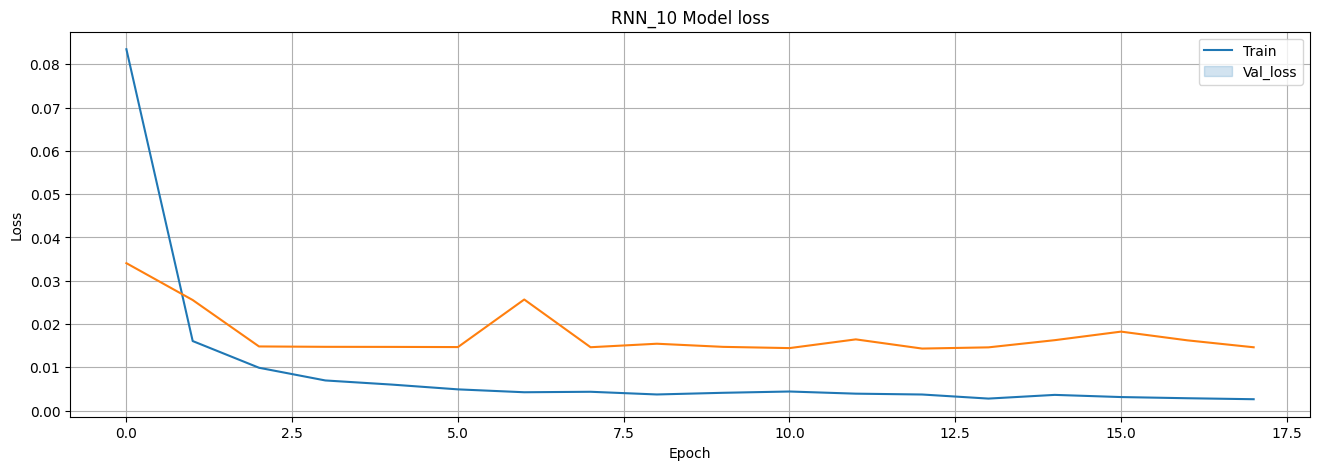

In [26]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_RNN_10.history["loss"])
sns.lineplot(data=history_RNN_10.history["val_loss"])
plt.title("RNN_10 Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val_loss"])
plt.grid()
plt.show()

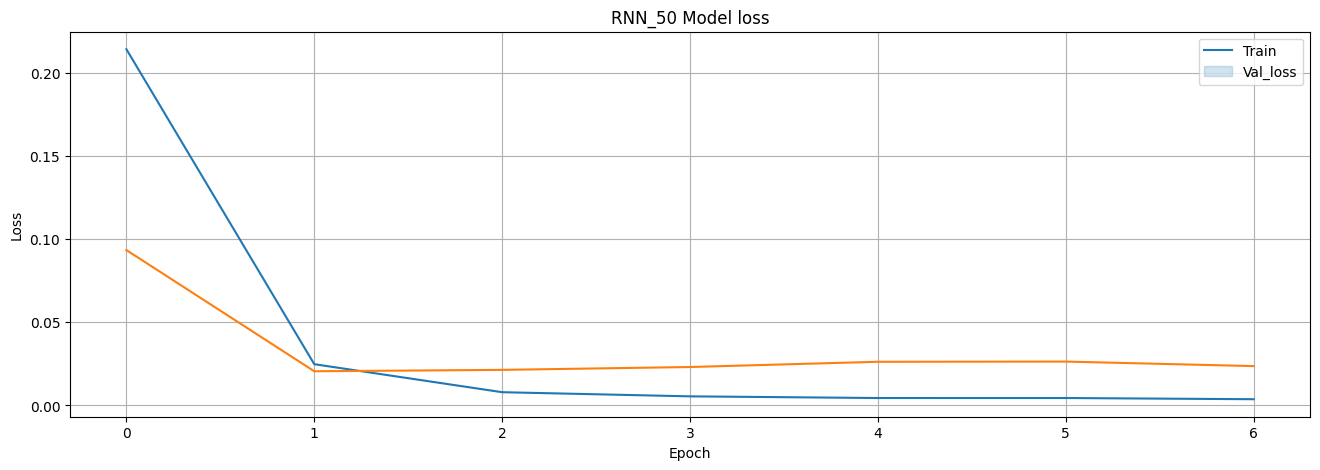

In [27]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_RNN_50.history["loss"])
sns.lineplot(data=history_RNN_50.history["val_loss"])
plt.title("RNN_50 Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val_loss"])
plt.grid()
plt.show()

In [28]:
history_RNN_50.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

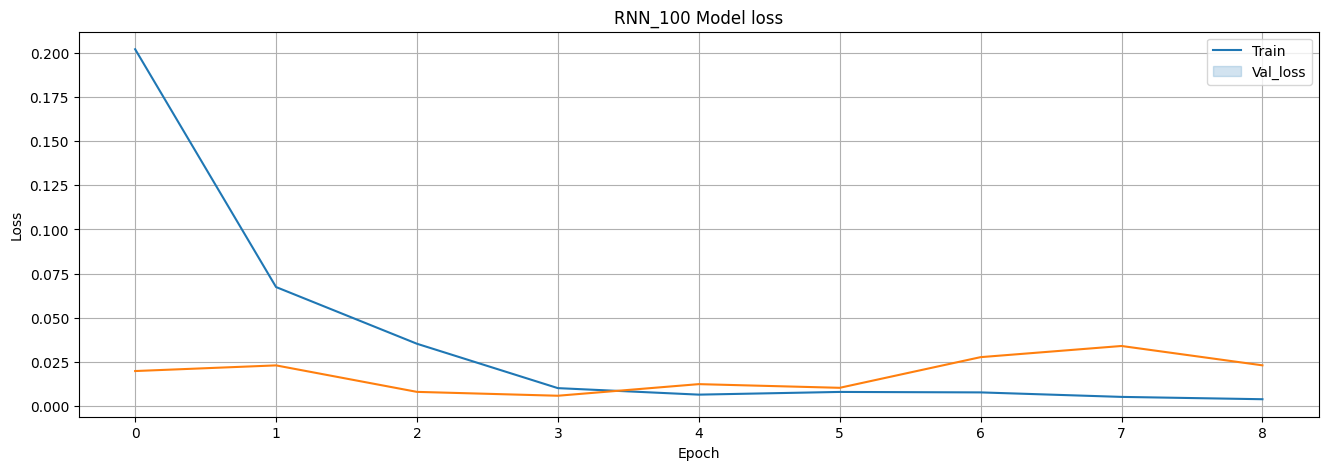

In [29]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_RNN_100.history["loss"])
sns.lineplot(data=history_RNN_100.history["val_loss"])
plt.title("RNN_100 Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val_loss"])
plt.grid()
plt.show()

In [31]:
# # Plotting Loss vs Epochs
# plt.figure(figsize =(5,3))
# plt.plot(history_RNN.history["loss"])
# plt.xlabel("Epochs")
# plt.ylabel("Losses")
# plt.title("Simple RNN model, Loss vs Epoch")
# plt.show()

In [127]:
def get_MAE(X_val,y_val,regressor_RNN):
    # Get the predicted values
    y_pred_scaled = regressor_RNN.predict(X_val)

    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
    y_val_unscaled = scaler_pred.inverse_transform(y_val.reshape(-1, 1))
    
    # Root Mean Square Error (RMSE)
    RMSE = mean_squared_error(y_val_unscaled, y_pred, squared=False)
    print(f'Root Mean Square Error (RMSE): {np.round(RMSE, 2)}')

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_val_unscaled, y_pred)
    print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled))) * 100
    print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled)) ) * 100
    print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
    print(len(y_pred))
    
    return True

In [128]:
print("regressor_RNN_10")
get_MAE(X_val_ten,y_val_ten,regressor_RNN_10)

print("regressor_RNN_50")
get_MAE(X_val_fifty,y_val_fifty,regressor_RNN_50)

print("regressor_RNN_100")
get_MAE(X_val_100,y_val_100,regressor_RNN_100)

regressor_RNN_10
4/4 [==============================] - 0s 2ms/step
Root Mean Square Error (RMSE): 12.33
Mean Absolute Error (MAE): 9.74
Mean Absolute Percentage Error (MAPE): 9.38 %
Median Absolute Percentage Error (MDAPE): 7.83 %
116
regressor_RNN_50
3/3 [==============================] - 0s 4ms/step
Root Mean Square Error (RMSE): 15.67
Mean Absolute Error (MAE): 12.7
Mean Absolute Percentage Error (MAPE): 12.93 %
Median Absolute Percentage Error (MDAPE): 12.08 %
76
regressor_RNN_100
1/1 [==============================] - 0s 42ms/step
Root Mean Square Error (RMSE): 15.46
Mean Absolute Error (MAE): 12.36
Mean Absolute Percentage Error (MAPE): 16.78 %
Median Absolute Percentage Error (MDAPE): 14.74 %
26


True

# LSTM

In [38]:
# initializing the LSTM
learning_rate=0.001

regressor_LSTM_10 = Sequential()

### sequence length 10, lr = 0,01
units = X_train_ten.shape[1] * X_train_ten.shape[2]
regressor_LSTM_10 = Sequential()

# adding first RNN layer and dropout regulatization
regressor_LSTM_10.add(LSTM(units = units , activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (X_train_ten.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_LSTM_10.add(LSTM(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_LSTM_10.add(LSTM(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_LSTM_10.add(Dense(units = 1))

# compiling RNN
opt = keras.optimizers.Adam(learning_rate)
regressor_LSTM_10.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [39]:
regressor_LSTM_10.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            11200     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 51,651
Trainable params: 51,651
Non-trainable params: 0
_________________________________________________________________


In [40]:
# initializing the LSTM
learning_rate=0.001

regressor_LSTM_50 = Sequential()

### sequence length 10, lr = 0,01
units = X_train_fifty.shape[1] * X_train_fifty.shape[2]
regressor_LSTM_50 = Sequential()

# adding first RNN layer and dropout regulatization
regressor_LSTM_50.add(LSTM(units = units , activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (X_train_fifty.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_LSTM_50.add(LSTM(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_LSTM_50.add(LSTM(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_LSTM_50.add(Dense(units = 1))

# compiling RNN
opt = keras.optimizers.Adam(learning_rate)
regressor_LSTM_50.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [41]:
regressor_LSTM_50.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 250)           256000    
                                                                 
 lstm_4 (LSTM)               (None, 50, 50)            60200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 336,451
Trainable params: 336,451
Non-trainable params: 0
_________________________________________________________________


In [42]:
# initializing the LSTM
learning_rate=0.001

regressor_LSTM_100 = Sequential()

### sequence length 10, lr = 0,01
units = X_train_100.shape[1] * X_train_100.shape[2]
regressor_LSTM_100 = Sequential()

# adding first RNN layer and dropout regulatization
regressor_LSTM_100.add(LSTM(units = units , activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (X_train_100.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_LSTM_100.add(LSTM(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_LSTM_100.add(LSTM(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_LSTM_100.add(Dense(units = 1))

# compiling RNN
opt = keras.optimizers.Adam(learning_rate)
regressor_LSTM_100.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [43]:
regressor_LSTM_100.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 500)          1012000   
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           110200    
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,142,451
Trainable params: 1,142,451
Non-trainable params: 0
_________________________________________________________________


In [44]:
# fitting the RNN
epochs = 50
batch_size = 32
history_LSTM_10 = regressor_LSTM_10.fit(X_train_ten, y_train_ten, epochs, batch_size , validation_data= (X_val_ten , y_val_ten), callbacks=[early_stop])
history_LSTM_50 = regressor_LSTM_50.fit(X_train_fifty, y_train_fifty, epochs, batch_size , validation_data= (X_val_fifty , y_val_fifty), callbacks=[early_stop])
history_LSTM_100 = regressor_LSTM_100.fit(X_train_100, y_train_100, epochs, batch_size , validation_data= (X_val_100 , y_val_100), callbacks=[early_stop])


Epoch 1/32
20/20 [==============================] - 3s 30ms/step - loss: 0.0275 - accuracy: 0.0020 - val_loss: 0.0262 - val_accuracy: 0.0086
Epoch 2/32
20/20 [==============================] - 0s 7ms/step - loss: 0.0031 - accuracy: 0.0020 - val_loss: 0.0208 - val_accuracy: 0.0086
Epoch 3/32
20/20 [==============================] - 0s 8ms/step - loss: 0.0022 - accuracy: 0.0020 - val_loss: 0.0216 - val_accuracy: 0.0086
Epoch 4/32
20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.0020 - val_loss: 0.0240 - val_accuracy: 0.0086
Epoch 5/32
20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.0020 - val_loss: 0.0204 - val_accuracy: 0.0086
Epoch 6/32
20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.0020 - val_loss: 0.0216 - val_accuracy: 0.0086
Epoch 7/32
20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.0020 - val_loss: 0.0222 - val_accuracy: 0.0086
Epoch 8/32
20/20 [=

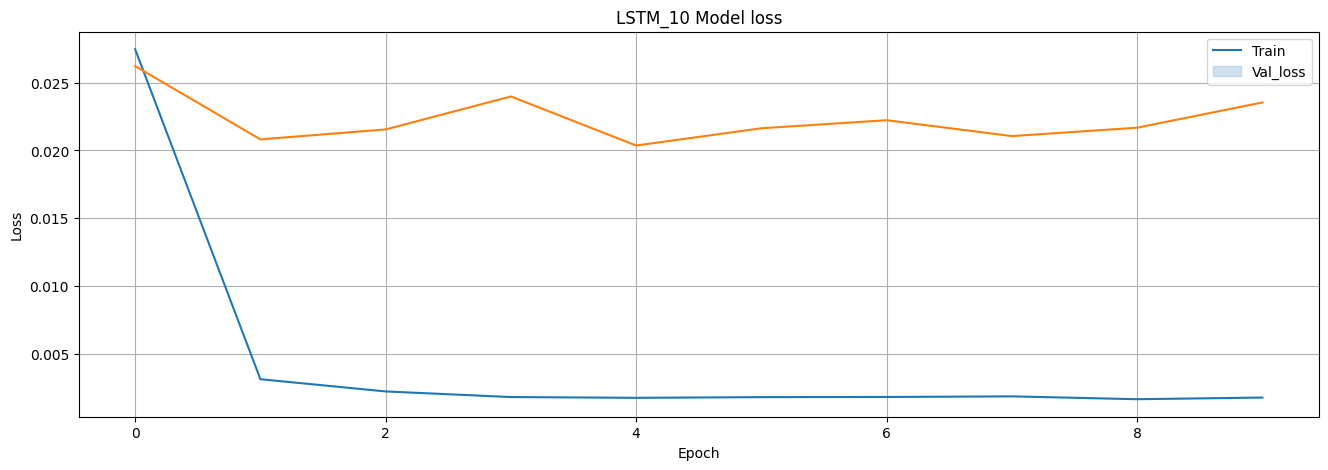

In [45]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_LSTM_10.history["loss"])
sns.lineplot(data=history_LSTM_10.history["val_loss"])
plt.title("LSTM_10 Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val_loss"])
plt.grid()
plt.show()

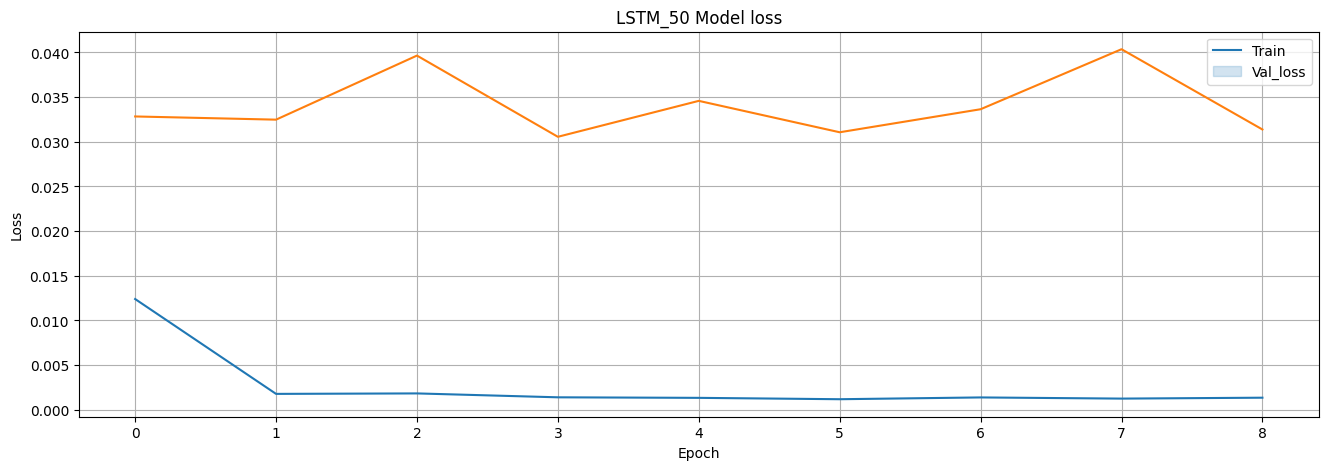

In [46]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_LSTM_50.history["loss"])
sns.lineplot(data=history_LSTM_50.history["val_loss"])
plt.title("LSTM_50 Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val_loss"])
plt.grid()
plt.show()

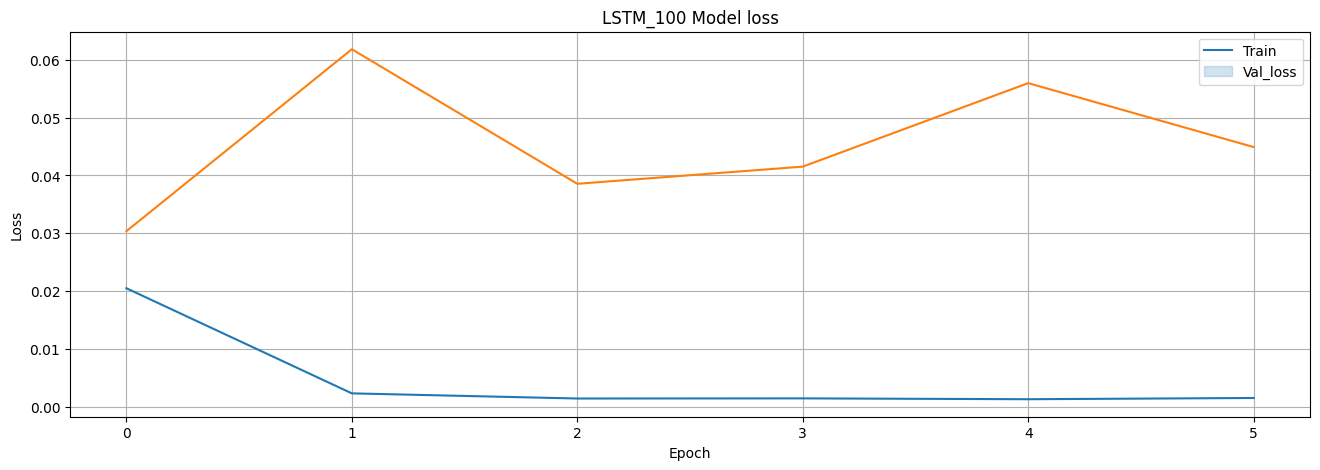

In [47]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_LSTM_100.history["loss"])
sns.lineplot(data=history_LSTM_100.history["val_loss"])
plt.title("LSTM_100 Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val_loss"])
plt.grid()
plt.show()

In [129]:
print("regressor_LSTM_10")
get_MAE(X_val_ten,y_val_ten,regressor_LSTM_10)

print("regressor_LSTM_50")
get_MAE(X_val_fifty,y_val_fifty,regressor_LSTM_50)

print("regressor_LSTM_100")
get_MAE(X_val_100,y_val_100,regressor_LSTM_100)

regressor_LSTM_10
4/4 [==============================] - 0s 2ms/step
Root Mean Square Error (RMSE): 15.63
Mean Absolute Error (MAE): 12.58
Mean Absolute Percentage Error (MAPE): 12.69 %
Median Absolute Percentage Error (MDAPE): 10.46 %
116
regressor_LSTM_50
3/3 [==============================] - 0s 17ms/step
Root Mean Square Error (RMSE): 18.05
Mean Absolute Error (MAE): 15.16
Mean Absolute Percentage Error (MAPE): 17.27 %
Median Absolute Percentage Error (MDAPE): 14.36 %
76
regressor_LSTM_100
1/1 [==============================] - 0s 96ms/step
Root Mean Square Error (RMSE): 21.59
Mean Absolute Error (MAE): 18.76
Mean Absolute Percentage Error (MAPE): 26.37 %
Median Absolute Percentage Error (MDAPE): 24.2 %
26


True

# GRU

In [49]:
# initializing the GRU
learning_rate=0.001

regressor_GRU_10 = Sequential()

### sequence length 10, lr = 0,01
units = X_train_ten.shape[1] * X_train_ten.shape[2]
regressor_GRU_10 = Sequential()

# adding first RNN layer and dropout regulatization
regressor_GRU_10.add(GRU(units = units , activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (X_train_ten.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_GRU_10.add(GRU(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_GRU_10.add(GRU(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_GRU_10.add(Dense(units = 1))

# compiling GRU
opt = keras.optimizers.Adam(learning_rate)
regressor_GRU_10.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [50]:
# initializing the GRU
learning_rate=0.001

regressor_GRU_50 = Sequential()

### sequence length 10, lr = 0,01
units = X_train_fifty.shape[1] * X_train_fifty.shape[2]
regressor_GRU_50 = Sequential()

# adding first RNN layer and dropout regulatization
regressor_GRU_50.add(GRU(units = units , activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (X_train_fifty.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_GRU_50.add(GRU(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_GRU_50.add(GRU(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_GRU_50.add(Dense(units = 1))

# compiling GRU
opt = keras.optimizers.Adam(learning_rate)
regressor_GRU_50.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [51]:
# initializing the GRU
learning_rate=0.001

regressor_GRU_100 = Sequential()

### sequence length 10, lr = 0,01
units = X_train_100.shape[1] * X_train_100.shape[2]
regressor_GRU_100 = Sequential()

# adding first RNN layer and dropout regulatization
regressor_GRU_100.add(GRU(units = units , activation = "tanh", dropout=0.2, return_sequences = True, input_shape = (X_train_100.shape[1],5)))

# adding second RNN layer and dropout regulatization
regressor_GRU_100.add(GRU(units = 50, activation = "tanh", dropout=0.2, return_sequences = True))

# adding third RNN layer and dropout regulatization
regressor_GRU_100.add(GRU(units = 50, activation = "tanh", return_sequences = False))

# adding the output layer
regressor_GRU_100.add(Dense(units = 1))

# compiling GRU
opt = keras.optimizers.Adam(learning_rate)
regressor_GRU_100.compile(optimizer = opt, loss = "mean_squared_error",metrics = ["accuracy"])


In [52]:
regressor_GRU_100.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 100, 500)          760500    
                                                                 
 gru_7 (GRU)                 (None, 100, 50)           82800     
                                                                 
 gru_8 (GRU)                 (None, 50)                15300     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 858,651
Trainable params: 858,651
Non-trainable params: 0
_________________________________________________________________


# Prediction

In [53]:
# fitting the RNN
epochs = 50
batch_size = 32
history_GRU_10 = regressor_GRU_10.fit(X_train_ten, y_train_ten, epochs, batch_size , validation_data= (X_val_ten , y_val_ten), callbacks=[early_stop])
history_GRU_50 = regressor_GRU_50.fit(X_train_fifty, y_train_fifty, epochs, batch_size , validation_data= (X_val_fifty , y_val_fifty), callbacks=[early_stop])
history_GRU_100 = regressor_GRU_100.fit(X_train_100, y_train_100, epochs, batch_size , validation_data= (X_val_100 , y_val_100), callbacks=[early_stop])



Epoch 1/32
20/20 [==============================] - 3s 28ms/step - loss: 0.0201 - accuracy: 0.0020 - val_loss: 0.0142 - val_accuracy: 0.0086
Epoch 2/32
20/20 [==============================] - 0s 7ms/step - loss: 0.0024 - accuracy: 0.0020 - val_loss: 0.0137 - val_accuracy: 0.0086
Epoch 3/32
20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.0020 - val_loss: 0.0142 - val_accuracy: 0.0086
Epoch 4/32
20/20 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.0020 - val_loss: 0.0141 - val_accuracy: 0.0086
Epoch 5/32
20/20 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 0.0020 - val_loss: 0.0141 - val_accuracy: 0.0086
Epoch 6/32
20/20 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 0.0020 - val_loss: 0.0142 - val_accuracy: 0.0086
Epoch 7/32
20/20 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.0020 - val_loss: 0.0146 - val_accuracy: 0.0086
Epoch 7: early stop

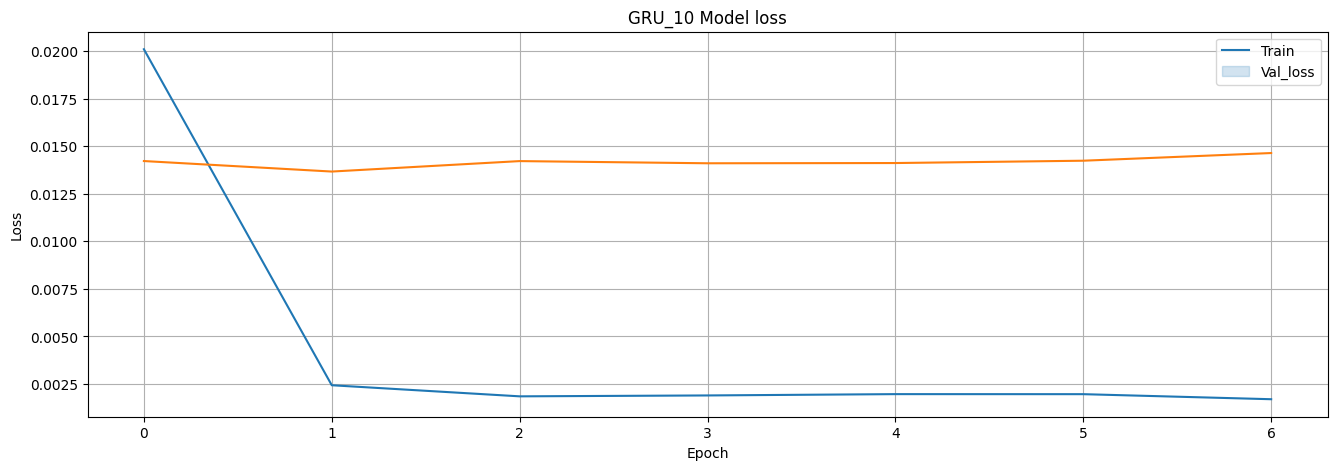

4/4 [==============================] - 0s 2ms/step
Median Absolute Error (MAE): 9.92


In [125]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_GRU_10.history["loss"])
sns.lineplot(data=history_GRU_10.history["val_loss"])
plt.title("GRU_10 Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val_loss"])
plt.grid()
plt.show()
# Get the predicted values
y_pred_scaled = regressor_GRU_10.predict(X_val_ten)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_val_unscaled = scaler_pred.inverse_transform(y_val_ten.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_val_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

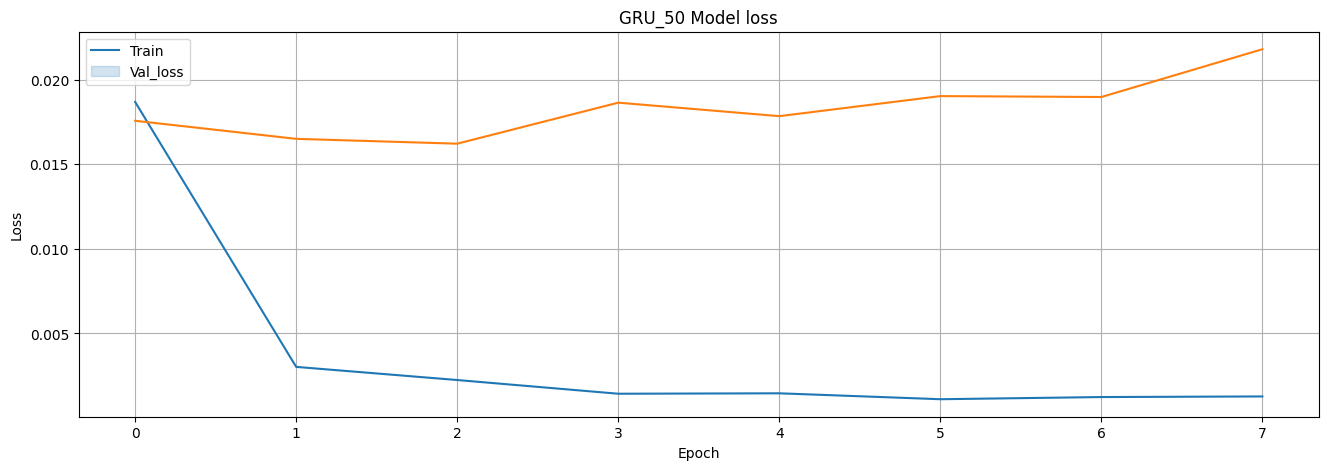

In [55]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_GRU_50.history["loss"])
sns.lineplot(data=history_GRU_50.history["val_loss"])
plt.title("GRU_50 Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val_loss"])
plt.grid()
plt.show()

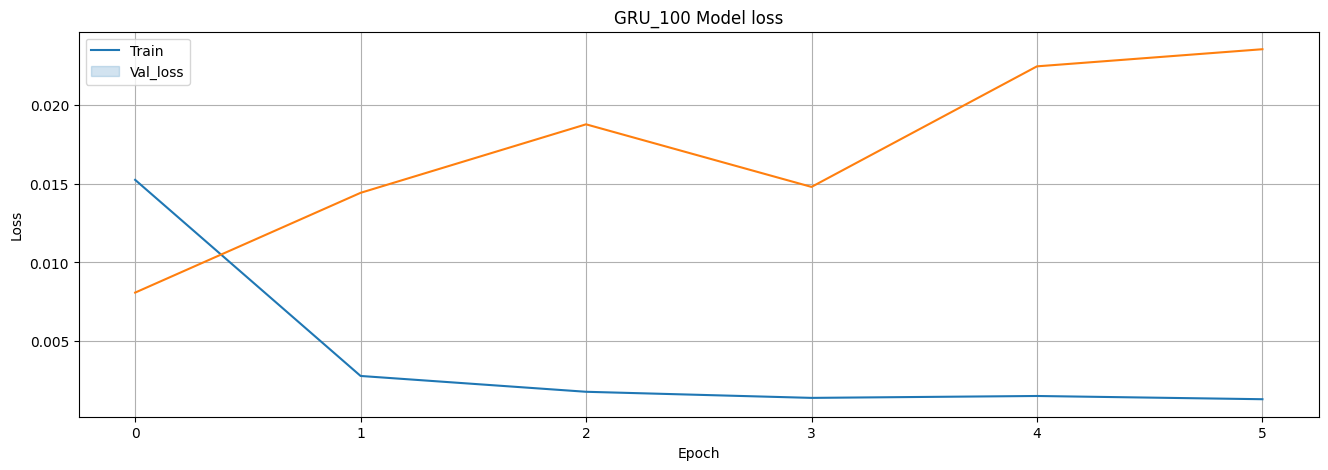

In [56]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_GRU_100.history["loss"])
sns.lineplot(data=history_GRU_100.history["val_loss"])
plt.title("GRU_100 Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val_loss"])
plt.grid()
plt.show()

In [130]:
print("regressor_GRU_10")
get_MAE(X_val_ten,y_val_ten,regressor_GRU_10)

print("regressor_GRU_50")
get_MAE(X_val_fifty,y_val_fifty,regressor_GRU_50)

print("regressor_GRU_100")
get_MAE(X_val_100,y_val_100,regressor_GRU_100)

regressor_GRU_10
4/4 [==============================] - 0s 2ms/step
Root Mean Square Error (RMSE): 12.33
Mean Absolute Error (MAE): 9.92
Mean Absolute Percentage Error (MAPE): 9.81 %
Median Absolute Percentage Error (MDAPE): 8.08 %
116
regressor_GRU_50
3/3 [==============================] - 0s 12ms/step
Root Mean Square Error (RMSE): 15.04
Mean Absolute Error (MAE): 12.31
Mean Absolute Percentage Error (MAPE): 13.46 %
Median Absolute Percentage Error (MDAPE): 11.81 %
76
regressor_GRU_100
1/1 [==============================] - 0s 85ms/step
Root Mean Square Error (RMSE): 15.63
Mean Absolute Error (MAE): 13.12
Mean Absolute Percentage Error (MAPE): 18.28 %
Median Absolute Percentage Error (MDAPE): 15.73 %
26


True

In [58]:
def prediction(model,window_size,X_train,y_train,X_val,y_val):
    
    train_predictions = model.predict(X_train).flatten()
    val_predictions = model.predict(X_val).flatten()
 #   test_predictions = model.predict(X_test).flatten()
    
    plt.figure(figsize=(15,5))
    plt.plot(data_training[window_size:].index, train_predictions)
    plt.plot(data_training[window_size:].index, y_train)
    
    plt.plot(data_validation[window_size:].index, val_predictions)
    plt.plot(data_validation[window_size:].index, y_val)
    
#     plt.plot(data_test[window_size:].index, test_predictions)
#     plt.plot(data_test[window_size:].index, y_test)
    plt.xticks(rotation=90)
    plt.grid
    
    return True


## prediction for RNN 10, 50,100

4/4 [==============================] - 0s 902us/step


True

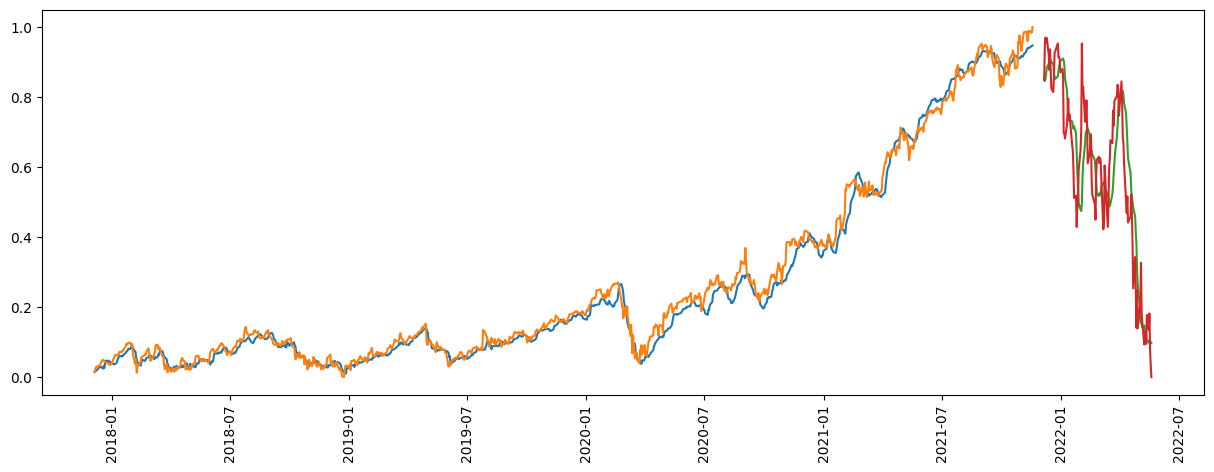

In [59]:
prediction(regressor_RNN_10, 10, X_train_ten, y_train_ten,X_val_ten, y_val_ten)

3/3 [==============================] - 0s 5ms/step


True

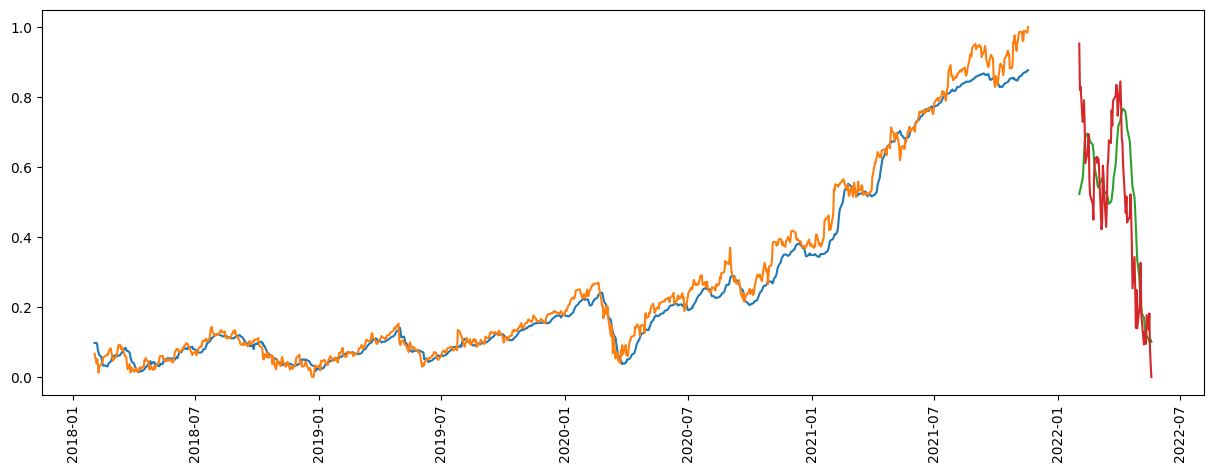

In [60]:
prediction(regressor_RNN_50, 50, X_train_fifty, y_train_fifty ,X_val_fifty, y_val_fifty)

1/1 [==============================] - 0s 31ms/step


True

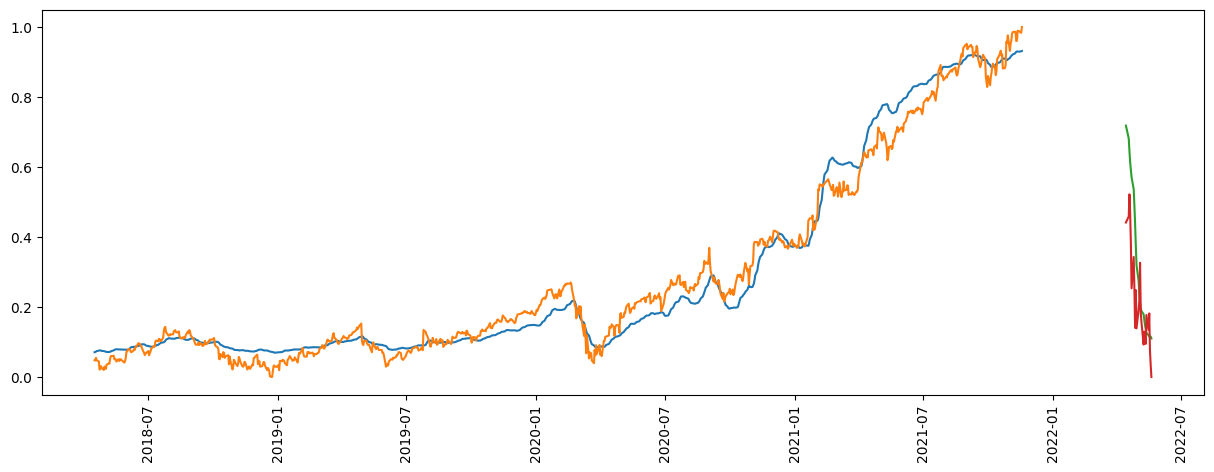

In [61]:
prediction(regressor_RNN_100, 100, X_train_100, y_train_100 ,X_val_100, y_val_100)

## prediction for LSTM 10, 50,100

4/4 [==============================] - 0s 2ms/step


True

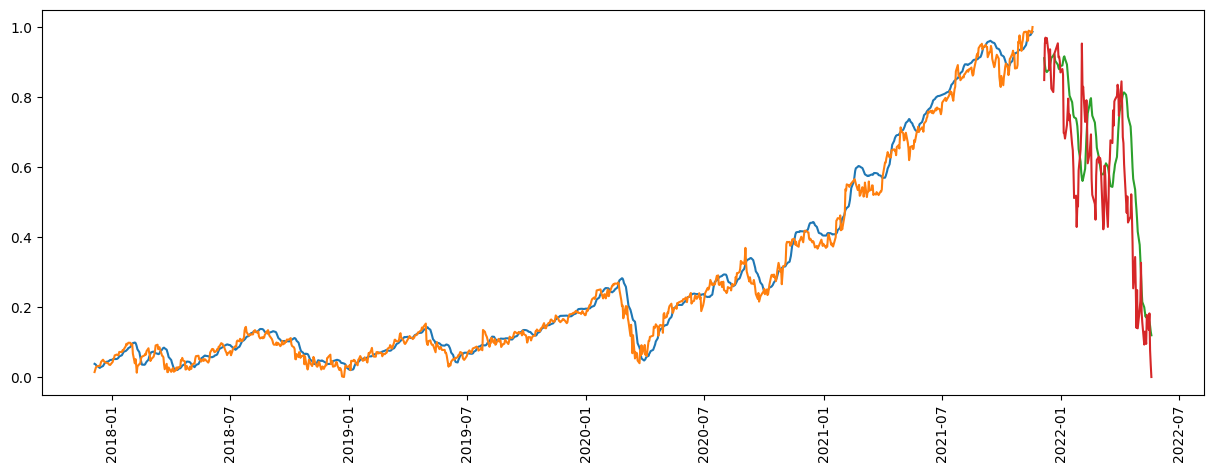

In [62]:
prediction(regressor_LSTM_10, 10, X_train_ten, y_train_ten,X_val_ten, y_val_ten)

3/3 [==============================] - 0s 14ms/step


True

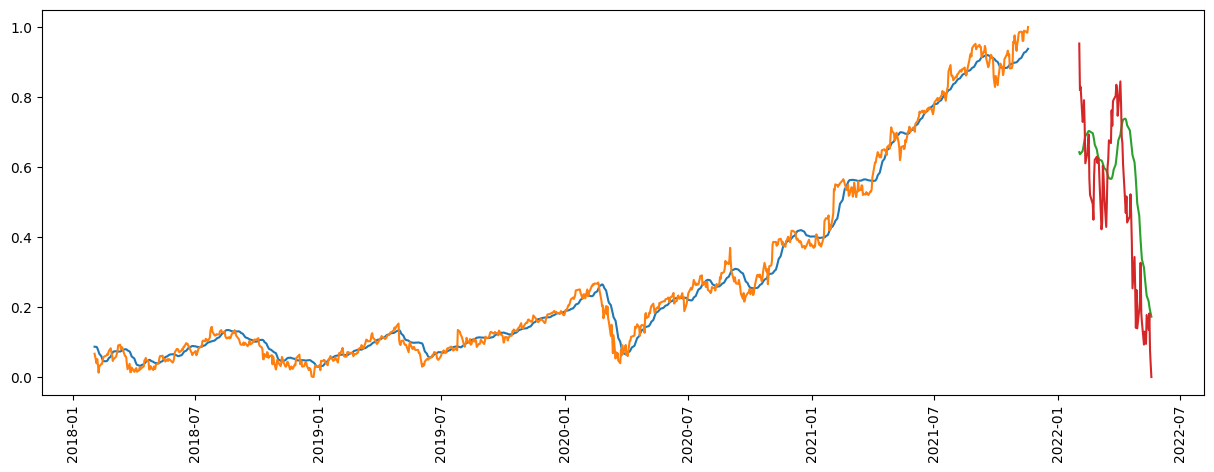

In [63]:
prediction(regressor_LSTM_50, 50, X_train_fifty, y_train_fifty ,X_val_fifty, y_val_fifty)

1/1 [==============================] - 0s 76ms/step


True

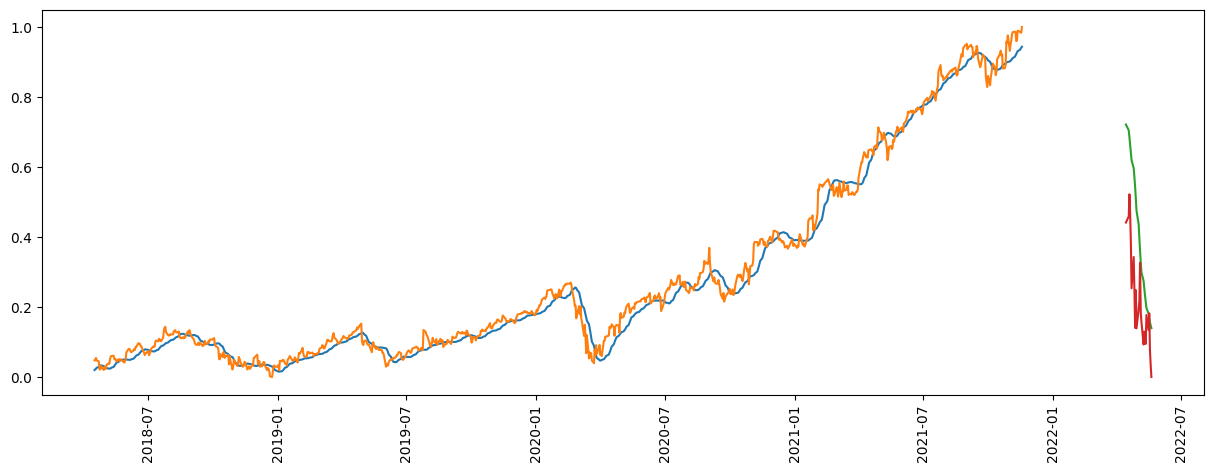

In [64]:
prediction(regressor_LSTM_100, 100, X_train_100, y_train_100 ,X_val_100, y_val_100)

## prediction for GRU 10, 50,100

4/4 [==============================] - 0s 1ms/step


True

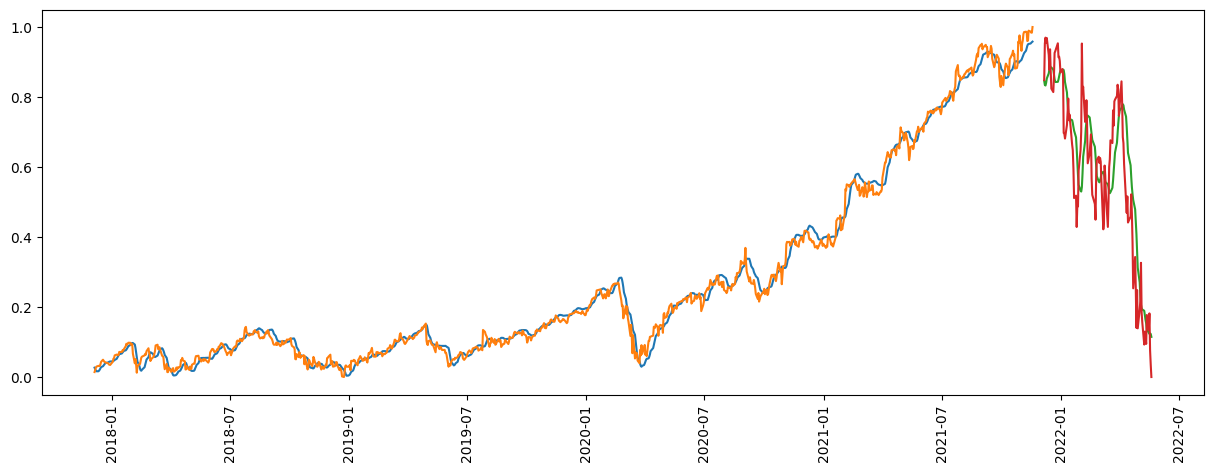

In [65]:
prediction(regressor_GRU_10, 10, X_train_ten, y_train_ten,X_val_ten, y_val_ten)

3/3 [==============================] - 0s 11ms/step


True

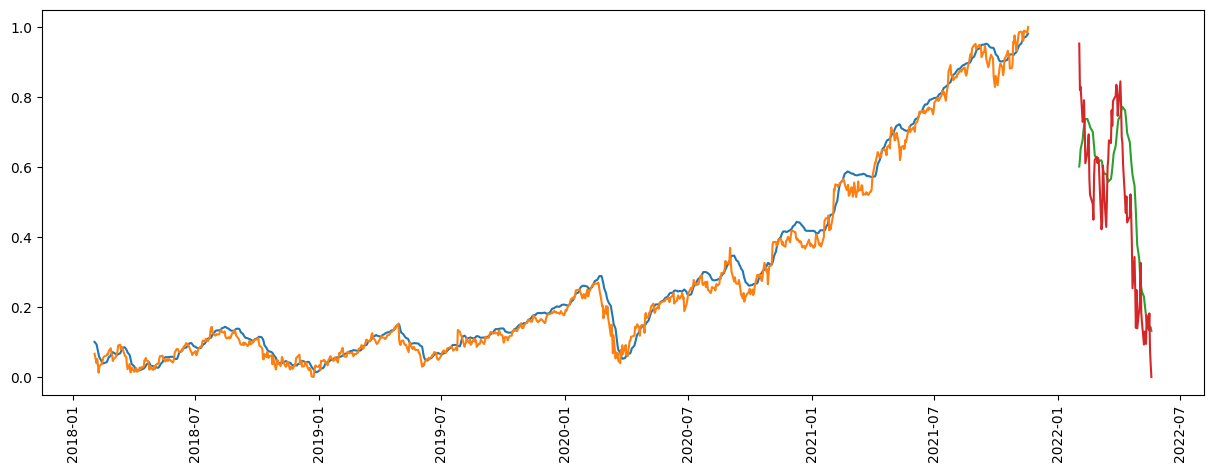

In [66]:
prediction(regressor_GRU_50, 50, X_train_fifty, y_train_fifty ,X_val_fifty, y_val_fifty)

1/1 [==============================] - 0s 58ms/step


True

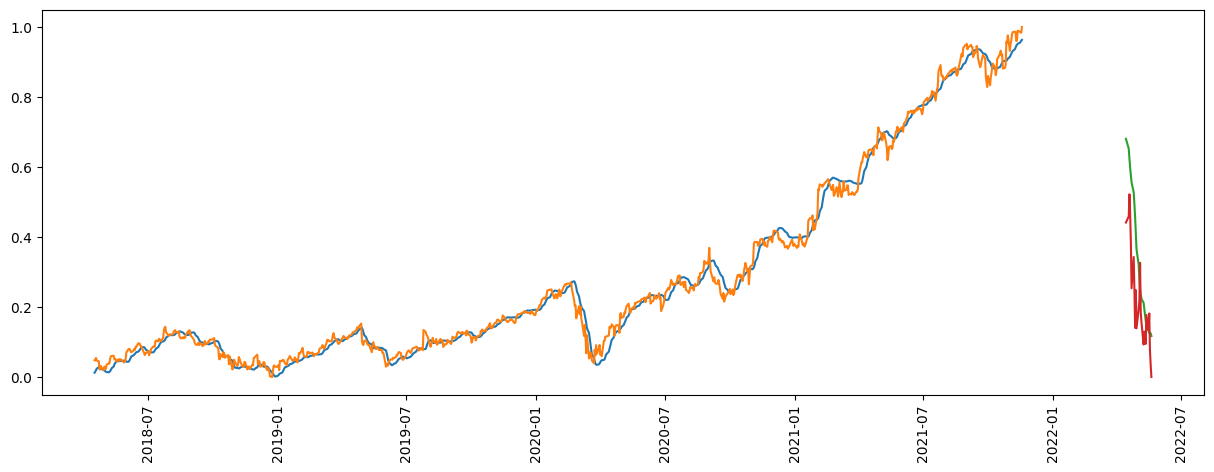

In [67]:
prediction(regressor_GRU_100, 100, X_train_100, y_train_100 ,X_val_100, y_val_100)

In [ ]:
#X_test_ten, X_test_fifty, X_test_100, y_test_ten,y_test_fifty,y_test_100

In [73]:
data_test

,Open,High,Low,Close,Volume
Date,,,,,
2022-05-23,110.103996,112.005501,109.154251,111.666496,31558000
2022-05-24,106.377502,106.394997,102.208000,105.926003,60386000
2022-05-25,105.141998,106.544701,104.211250,105.839500,37900000
2022-05-26,106.050499,108.955254,105.487999,108.295998,30288000
2022-05-27,109.788498,112.867996,109.550003,112.799004,29924000
...,...,...,...,...,...
2022-11-14,95.500000,97.180000,95.112999,96.029999,24170100
2022-11-15,98.669998,100.419998,97.019997,98.720001,31831000
2022-11-16,98.019997,99.849998,97.902000,98.989998,24660200


In [91]:
regressor_RNN_10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 50)            2800      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10, 50)            5050      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 12,951
Trainable params: 12,951
Non-trainable params: 0
_________________________________________________________________


In [103]:
df_temp = scaled_data_test[-11:-1]
#new_df = df_temp

# N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
# last_N_days = new_df[-sequence_length:].values
# last_N_days_scaled = y_test_ten[-1]

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(df_temp)
# X_test_new
# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = regressor_RNN_10.predict(np.array(X_test_new))
# pred_price_scaled
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(df_temp[-1][3], 2)

predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
# print(f'The close price for {"stockname"} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 11ms/step
The predicted close price is 76.70999908447266 (+99.5%)


In [110]:
def prediction_price(model,sequence_length):
    df_temp = scaled_data_test[-sequence_length:-1]
    #new_df = df_temp

    # N = sequence_length

    # Get the last N day closing price values and scale the data to be values between 0 and 1
    # last_N_days = new_df[-sequence_length:].values
    # last_N_days_scaled = y_test_ten[-1]

    # Create an empty list and Append past N days
    X_test_new = []
    X_test_new.append(df_temp)
    # X_test_new
    # Convert the X_test data set to a numpy array and reshape the data
    pred_price_scaled = model.predict(np.array(X_test_new))
    # pred_price_scaled
    pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

    # Print last price and predicted price for the next day
    price_today = np.round(df_temp[-1][3], 2)

    predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
    change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

    plus = '+'; minus = ''
    
    # print(f'The close price for {"stockname"} at {end_date} was {price_today}')
    print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')
          
    return True

In [122]:
all_model=[regressor_RNN_10, regressor_RNN_50, regressor_RNN_100, regressor_LSTM_10, regressor_LSTM_50,regressor_LSTM_100, regressor_GRU_10, regressor_GRU_50, regressor_GRU_100]
all_sl=[10,50,100,10,50,100,10,50,100]    

for i ,j in zip(all_model, all_sl):
     prediction_price(i,j)
    

1/1 [==============================] - 0s 11ms/step
The predicted close price is 80.76000213623047 (+99.53%)
1/1 [==============================] - 0s 10ms/step
The predicted close price is 69.12000274658203 (+99.45%)
1/1 [==============================] - 0s 10ms/step
The predicted close price is 71.38999938964844 (+99.47%)
1/1 [==============================] - 0s 433ms/step
The predicted close price is 68.16000366210938 (+99.44%)
1/1 [==============================] - 0s 405ms/step
The predicted close price is 70.91000366210938 (+99.46%)
1/1 [==============================] - 1s 1s/step
The predicted close price is 67.9800033569336 (+99.44%)
1/1 [==============================] - 0s 381ms/step
The predicted close price is 77.98999786376953 (+99.51%)
1/1 [==============================] - 0s 375ms/step
The predicted close price is 77.08000183105469 (+99.51%)
1/1 [==============================] - 0s 387ms/step
The predicted close price is 74.87000274658203 (+99.49%)


array([[[0.45042094, 0.45083071, 0.44202531, 0.49454185, 0.180169  ],
        [0.48329264, 0.50531178, 0.51337876, 0.54430065, 0.27173038],
        [0.30562349, 0.32661396, 0.29171044, 0.28763651, 1.        ],
        [0.23906538, 0.23481327, 0.22166853, 0.23127698, 0.69415691],
        [0.19070898, 0.28084986, 0.23276496, 0.33231796, 0.3730495 ],
        [0.27900021, 0.2669571 , 0.28672611, 0.28357467, 0.27100375],
        [0.27383848, 0.26191769, 0.18310605, 0.17796401, 0.5047817 ],
        [0.14669933, 0.12939254, 0.09338942, 0.09088606, 0.51061218],
        [0.02268403, 0.        , 0.        , 0.        , 0.59740062],
        [0.        , 0.0049033 , 0.01128017, 0.08149274, 0.45110797]],

       [[0.48329264, 0.50531178, 0.51337876, 0.54430065, 0.27173038],
        [0.30562349, 0.32661396, 0.29171044, 0.28763651, 1.        ],
        [0.23906538, 0.23481327, 0.22166853, 0.23127698, 0.69415691],
        [0.19070898, 0.28084986, 0.23276496, 0.33231796, 0.3730495 ],
        [0.2790002

In [ ]:
#make a function pred last day vs actual last day
def predict_last_day(X_test,y_test):
    # Get the predicted values
  
    return True


In [ ]:
y_pred_scaled = regressor_RNN.predict(X_val)

In [110]:
# Get the predicted values
y_pred_scaled = regressor_RNN.predict(X_val)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_val_unscaled = scaler_pred.inverse_transform(y_val.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_val_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_val_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

NameError: name 'X_val' is not defined

In [109]:
# The date from which on the date is displayed
display_start_date = "2004-08-19" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data['Close'][window_size:training_size +1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data['Close'][window_size+training_size: validation_size]).rename(columns={'Close': 'y_test'})

# validation_size

valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# # Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel("Google", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

NameError: name 'window_size' is not defined

In [53]:
# # y_pred = y_pred*scale
# # y_test = y_test*scale
# # Model predictions for train data
# y_pred_RNN_X = regressor_RNN.predict(X_train)  # predictions

113/113 [==============================] - 0s 3ms/step


In [ ]:
# # check the scale of every column
# scaler_RNN.scale_

In [ ]:
# scale = 1/1.64134652e-02,
# scale

In [ ]:
# y_pred_RNN_X = y_pred_RNN_X *scale
# y_test_RNN_X = y_test_RNN_X *scale

In [ ]:
# # Visualising the results
# plt.figure(figsize=(14,5))
# plt.plot(y_test_RNN_X , color = 'red', label = 'Real Google Stock Price')
# plt.plot(y_pred_RNN_X , color = 'blue', label = 'Predicted Google Stock Price')
# plt.title('Google Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('Google Stock Price')
# plt.legend()
# plt.show()

In [ ]:
# ## Prepare val dataset
# past_60_days = data_training.tail(60)
# df_val = past_60_days.append(data_validation, ignore_index = True)
# df_val = df_val.drop(['Date', 'Adj Close'], axis = 1)
# df_val.head(10)

In [ ]:
# val_inputs = scaler.transform(df_val)
# val_inputs

In [ ]:
# # We have to prepare the val data like the training data.
# X_val = []
# y_val = []

# for i in range(60, val_inputs.shape[0]):
#     X_val.append(val_inputs[i-60:i])
#     y_val.append(val_inputs[i, 0])

# X_val, y_val = np.array(X_val), np.array(y_val)
# X_val.shape, y_val.shape

In [ ]:
# #Model predictions for train data
# val_pred_RNN = regressor_RNN.predict(X_train)  # predictions


In [ ]:
# scaler.scale_

In [ ]:
# # initializing the LSTM
# regressor = Sequential()

# regressor.add(LSTM(units = 60, activation = "tanh", return_sequences = True, input_shape = (X_train.shape[1], 5)))
# regressor.add(Dropout(0.2))

# regressor.add(LSTM(units = 60, activation = "tanh", return_sequences = True))
# regressor.add(Dropout(0.2))

# regressor.add(LSTM(units = 80, activation = "tanh", return_sequences = True))
# regressor.add(Dropout(0.2))

# regressor.add(LSTM(units = 120, activation = "tanh", return_sequence))
# regressor.add(Dropout(0.2))

# regressor.add(Dense(units = 1))

In [ ]:
# regressor.summary()

In [ ]:
# regressor.compile(optimizer=Adam(learning_rate=0.001), loss = 'mean_squared_error')
# regressor.fit(X_train, y_train, epochs=50, batch_size=32)


In [ ]:
# past_60_days = data_training.tail(60)
# df = past_60_days.append(data_test, ignore_index = True)
# df = df.drop(['Date', 'Adj Close'], axis = 1)
# df.head(10)

In [ ]:
# inputs = scaler.transform(df)
# inputs

In [ ]:
# # We have to prepare the test data like the training data.
# X_test = []
# y_test = []

# for i in range(60, inputs.shape[0]):
#     X_test.append(inputs[i-60:i])
#     y_test.append(inputs[i, 0])

# X_test, y_test = np.array(X_test), np.array(y_test)
# X_test.shape, y_test.shape


In [ ]:
# y_pred = regressor.predict(X_test)

In [ ]:
# scaler_RNN.

In [ ]:
# scale = 1/1.12669064e-02,
# scale

In [ ]:
# y_pred = y_pred*scale
# y_test = y_test*scale


In [ ]:
# # Visualising the results
# plt.figure(figsize=(14,5))
# plt.plot(y_test, color = 'red', label = 'Real Google Stock Price')
# plt.plot(y_pred, color = 'blue', label = 'Predicted Google Stock Price')
# plt.title('Google Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('Google Stock Price')
# plt.legend()
# plt.show()